In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
data = pd.read_csv('heart.csv')

In [3]:
data

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3,0
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3,0
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3,0
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3,0


#  Outliers Detection and Removal

C:\Users\clzin\miniconda3\envs\DSA\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Users\clzin\miniconda3\envs\DSA\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Users\clzin\miniconda3\envs\DSA\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\U

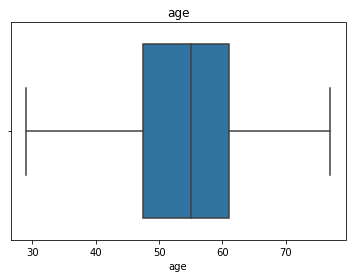

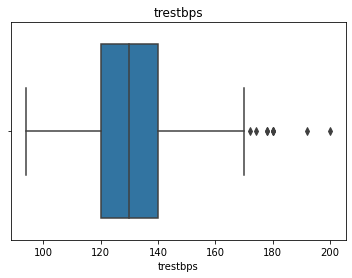

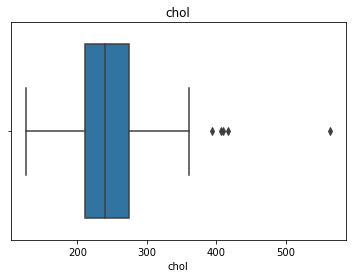

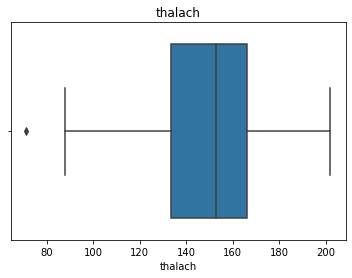

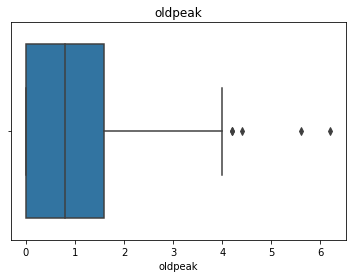

In [4]:
data_cont = data[['age','trestbps','chol','thalach','oldpeak']]
for figure in data_cont:
    plt.figure()
    plt.title(figure)
    ax = sns.boxplot(data[figure])

In [5]:
from sklearn.preprocessing import StandardScaler

In [6]:
scaler_1 = StandardScaler(with_mean=True, with_std=True)  # 0 mean for z_score
scaler_2 = StandardScaler(with_mean=False, with_std=True)  # actual mean 

In [7]:
no_mean_data = data.copy()

In [8]:
no_mean_data[['age','trestbps','chol','thalach','oldpeak']] = scaler_1.fit_transform(data[['age','trestbps','chol','thalach','oldpeak']])

In [9]:
from scipy import stats

In [10]:
z= np.abs(stats.zscore(no_mean_data))

In [11]:
row_to_remove = np.where(z > 3) # with z <= 2 there are no outliers

In [12]:
data = data.drop(row_to_remove[0], axis=0)

In [13]:
data[['age','trestbps','chol','thalach','oldpeak']] = scaler_2.fit_transform(data[['age','trestbps','chol','thalach','oldpeak']])

# Feature Selection
## We will try different methods 
### Univariate feature selection

In [14]:
from sklearn.feature_selection import chi2, f_classif
from math import log10

In [15]:
cat = data[[data.columns[i] for i in range(len(data.columns)) if data.iloc[:,i].dtypes == 'int64']] 
cont = data[[data.columns[i] for i in range(len(data.columns)) if data.iloc[:,i].dtypes == 'float64']]

<AxesSubplot:>

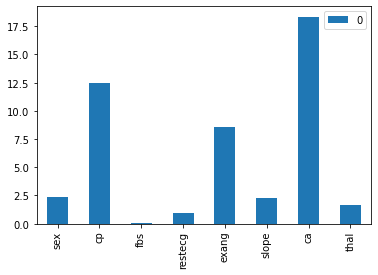

In [16]:
chi_scores, chi_pval = chi2(cat.drop('target', axis=1), cat['target'])
log10_pval = -np.log10(chi_pval)
columns = cat.drop('target', axis=1).columns
pd.DataFrame(log10_pval, index=columns).plot.bar()

<AxesSubplot:>

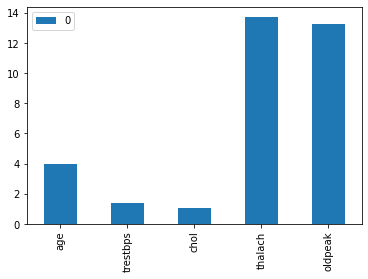

In [17]:
f_scores, f_pval = f_classif(cont, cat['target'])
log10_f_pval = -np.log10(f_pval)
pd.DataFrame(log10_f_pval, index=cont.columns).plot.bar()

fbs probably is not a good predictor

In [18]:
datasets = []

In [19]:
univariate_dataset = data.drop(['fbs','target'], axis=1)
univariate_dataset.name = 'univariate_dataset'
datasets.append(univariate_dataset)

### SelectFromModel

In [20]:
from sklearn.feature_selection import SelectFromModel

In [21]:
X = data.iloc[:,0:-1]
y = data.iloc[:,-1]

In [22]:
from sklearn.svm import LinearSVC

lsvc = LinearSVC(C=0.01, penalty="l1", dual=False).fit(X, y)
model = SelectFromModel(lsvc, prefit=True)
SelectFM_SVC_dataset = model.transform(X)
SelectFM_SVC_dataset = pd.DataFrame(SelectFM_SVC_dataset)
SelectFM_SVC_dataset.name = 'SelectFM_SVC_dataset'

datasets.append(SelectFM_SVC_dataset)

In [23]:
from sklearn.ensemble import ExtraTreesClassifier

tree_clf = ExtraTreesClassifier(n_estimators=70)
tree_clf = tree_clf.fit(X, y)
model = SelectFromModel(tree_clf, prefit=True)
SelectFM_Tree_dataset = model.transform(X)
SelectFM_Tree_dataset = pd.DataFrame(SelectFM_Tree_dataset)
SelectFM_Tree_dataset.name = 'SelectFM_Tree_dataset'


datasets.append(SelectFM_Tree_dataset)

### Sequential Feature Selection

In [24]:
from sklearn.feature_selection import SequentialFeatureSelector

In [25]:
lsvc = LinearSVC(C=0.01, penalty="l1", dual=False)
tree_clf = ExtraTreesClassifier(n_estimators=70)

In [26]:
sfs = SequentialFeatureSelector(lsvc, n_features_to_select=9)
sfs_back = SequentialFeatureSelector(lsvc, n_features_to_select=9, direction='backward')

Sequential_SVC_dataset = sfs.fit_transform(X, y)
Sequential_SVC_dataset = pd.DataFrame(Sequential_SVC_dataset)
Sequential_SVC_dataset.name = 'Sequential_SVC_dataset'


datasets.append(Sequential_SVC_dataset)

Sequential_back_SVC_dataset = sfs_back.fit_transform(X, y) 
Sequential_back_SVC_dataset = pd.DataFrame(Sequential_back_SVC_dataset)
Sequential_back_SVC_dataset.name = 'Sequential_back_SVC_dataset'


datasets.append(Sequential_back_SVC_dataset)

In [27]:
sfs = SequentialFeatureSelector(tree_clf, n_features_to_select=9)
sfs_back = SequentialFeatureSelector(tree_clf, n_features_to_select=9, direction='backward')

Sequential_Tree_dataset = sfs.fit_transform(X, y)
Sequential_Tree_dataset = pd.DataFrame(Sequential_Tree_dataset)
Sequential_Tree_dataset.name = 'Sequential_Tree_dataset'


datasets.append(Sequential_Tree_dataset)

Sequential_back_Tree_dataset = sfs_back.fit_transform(X, y) 
Sequential_back_Tree_dataset = pd.DataFrame(Sequential_back_Tree_dataset)
Sequential_back_Tree_dataset.name = 'Sequential_back_Tree_dataset'


datasets.append(Sequential_back_Tree_dataset)

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
import xgboost as xgb

In [29]:
models = [
    LogisticRegression(random_state=0, max_iter=1000),
    DecisionTreeClassifier(random_state=0, max_depth=5),
    RandomForestClassifier(max_depth=5, random_state=0),
    SVC(gamma='auto', kernel='linear'),
    xgb.XGBClassifier(objective='binary:logistic', use_label_encoder=False,
                              n_estimators = 10000, n_jobs=10, early_stopping_rounds=10),
    
]

In [30]:
models_names = [
    'Logistic Regression',
    'Decision Tree',
    'Random Forest',
    'SVC',
    'XGBoost'
]

In [31]:
results = {}
for dtst in datasets:
    scores = {}
    counter = 0
    for model in models:
        score = cross_val_score(model, dtst, y, cv=3)
        scores[models_names[counter]] = np.mean(score)
        counter += 1
    results[dtst.name] = scores   

In [32]:
results_accuracy = pd.DataFrame(results)

In [33]:
results = {}
for dtst in datasets:
    scores = {}
    counter = 0
    for model in models:
        score = cross_val_score(model, dtst, y, cv=3, scoring='roc_auc')
        scores[models_names[counter]] = np.mean(score)
        counter += 1
    results[dtst.name] = scores   

In [34]:
results_ROC_AUC = pd.DataFrame(results)

In [35]:
results_accuracy

,univariate_dataset,SelectFM_SVC_dataset,SelectFM_Tree_dataset,Sequential_SVC_dataset,Sequential_back_SVC_dataset,Sequential_Tree_dataset,Sequential_back_Tree_dataset
Logistic Regression,0.836111,0.822186,0.836184,0.815314,0.832639,0.822186,0.829130
Decision Tree,0.721089,0.794408,0.790936,0.742288,0.790826,0.769956,0.745431
Random Forest,0.829203,0.822149,0.801425,0.815314,0.822222,0.832639,0.822113
SVC,0.832675,0.811769,0.822222,0.801352,0.808224,0.804751,0.815205
XGBoost,0.801243,0.759393,0.773319,0.780446,0.776754,0.829130,0.776827


In [37]:
results_ROC_AUC

,univariate_dataset,SelectFM_SVC_dataset,SelectFM_Tree_dataset,Sequential_SVC_dataset,Sequential_back_SVC_dataset,Sequential_Tree_dataset,Sequential_back_Tree_dataset
Logistic Regression,0.910065,0.897129,0.899534,0.886784,0.899382,0.907264,0.895880
Decision Tree,0.702841,0.778763,0.777812,0.759847,0.789903,0.754527,0.742808
Random Forest,0.907655,0.892030,0.897759,0.876489,0.901703,0.916897,0.892854
SVC,0.910574,0.895506,0.900015,0.881108,0.896465,0.909067,0.894227
XGBoost,0.881389,0.844843,0.846801,0.853250,0.851026,0.893110,0.862957


In [36]:
model_accuracy = pd.DataFrame(results_accuracy.mean(axis=1)).rename(columns={0:'mean_accuracy'})
dataset_accuracy = pd.DataFrame(results_accuracy.mean(axis=0)).rename(columns={0:'mean_accuracy'})
model_ROC_AUC = pd.DataFrame(results_ROC_AUC.mean(axis=1)).rename(columns={0:'mean_roc_auc_score'})
dataset_ROC_AUC = pd.DataFrame(results_ROC_AUC.mean(axis=0)).rename(columns={0:'mean_roc_auc_score'})

In [39]:
model_scoring = model_accuracy.join(model_ROC_AUC)
dataset_scoring = dataset_accuracy.join(dataset_ROC_AUC)

In [40]:
model_scoring

,mean_accuracy,mean_roc_auc_score
Logistic Regression,0.827679,0.899434
Decision Tree,0.764991,0.758072
Random Forest,0.820724,0.897912
SVC,0.813743,0.898137
XGBoost,0.785302,0.861911


In [41]:
dataset_scoring

,mean_accuracy,mean_roc_auc_score
univariate_dataset,0.804064,0.862505
SelectFM_SVC_dataset,0.801981,0.861654
SelectFM_Tree_dataset,0.804817,0.864384
Sequential_SVC_dataset,0.790943,0.851496
Sequential_back_SVC_dataset,0.806133,0.867696
Sequential_Tree_dataset,0.811732,0.876173
Sequential_back_Tree_dataset,0.797741,0.857745
